This code implements a complete pipeline for building and training a Skip-Gram word embedding model using PyTorch, starting from text preprocessing and tokenization to model training and visualization of word embeddings. It begins by importing essential libraries such as pandas, numpy, matplotlib, and PyTorch modules for handling datasets, models, and training. A text file is loaded, and a custom tokenizer is used to preprocess the text by removing HTML tags, non-alphanumeric characters, and identifying emoticons. The processed tokens are counted, and a vocabulary is constructed with <pad> and <unk> tokens for padding and unknown words, respectively. Words are mapped to scalar indices, enabling efficient conversion between words and their representations.

Using the tokenized text, a sliding window mechanism is employed to generate training pairs of input words and their context words, which are further converted into PyTorch tensors and packaged into a custom TextDataset class. This dataset is split into training and validation sets, with data loaders managing batch processing. The Skip-Gram model is defined as a PyTorch neural network, consisting of an embedding layer to generate word vectors and a linear output layer to predict context words from input words. Cross-entropy loss is used as the loss function, and the model is optimized using the Adam optimizer.

The training loop iterates through multiple epochs, computing the loss and updating model parameters via backpropagation, while validation loss is calculated after each epoch to monitor performance. The model's embedding weights, which represent the learned word embeddings, are extracted and visualized using t-SNE to reduce dimensionality. A scatter plot with annotations is generated to depict the relationships between words in the embedding space. Additionally, a k-d tree is constructed to enable efficient similarity searches within the embedding space. This pipeline provides a robust framework for training and visualizing word embeddings, illustrating the relationships between words and enabling applications like semantic similarity and downstream NLP tasks.

In [60]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#PyTorch Libraries
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [61]:
import re
from collections import Counter, OrderedDict

In [62]:
with open('BMC Summary.sty', 'r', encoding="utf8") as file:
    txt = file.read()

In [63]:
txt

'probability of both events happening and probability of either event happening when looking at list of outcomes defintions looking at frequency table finding prob of some event\nMultiple problems with the Lagrangian.\nUsing ratio test to determine whether a series converges or not. Watching out for the common pitfall of not plugging in n plus one properly. Brief glimpse at power series and radius of convergence.\nUsing cross product and dot product formulas and identities to solve word problems. This involved interpreting the word problems and using given information to set up equations to solve for unknowns, i.e. finding the area of a triangle, the angle between two vectors, or the magnitude of a cross-product.\nWent through several WebWork problems on finding equation of a plane, normal vectors, finding the angle of intersection, etc.\ntwo dimensional motion problems, in both Calculus three and Physics one. Using the fact that the horizontal and vertical components are separate.\npa

In [64]:
len(txt)

587348

In [65]:
def tokenizer(text):
    ## Tokenize:

    #Remove HTML tags:
    text2 = re.sub('<[^>]*>', '', text)

    #Get any emoticons: Unlikely to have any of these in classic text, but eh
    emoticons = re.findall('(?::|;|=)(?:-)(?:\)|\(|D|P)', text2.lower())
    emoticons

    #Remove non-alphanumeric:
    #And append any emoticons:
    text2 = re.sub('[\W]+', ' ', text2.lower()) + ' '.join(emoticons).replace('-', '')

    #Split into individual tokens:
    tokenized = text2.split()
    
    #Return:
    return tokenized

In [66]:
tokenizer(txt)

['probability',
 'of',
 'both',
 'events',
 'happening',
 'and',
 'probability',
 'of',
 'either',
 'event',
 'happening',
 'when',
 'looking',
 'at',
 'list',
 'of',
 'outcomes',
 'defintions',
 'looking',
 'at',
 'frequency',
 'table',
 'finding',
 'prob',
 'of',
 'some',
 'event',
 'multiple',
 'problems',
 'with',
 'the',
 'lagrangian',
 'using',
 'ratio',
 'test',
 'to',
 'determine',
 'whether',
 'a',
 'series',
 'converges',
 'or',
 'not',
 'watching',
 'out',
 'for',
 'the',
 'common',
 'pitfall',
 'of',
 'not',
 'plugging',
 'in',
 'n',
 'plus',
 'one',
 'properly',
 'brief',
 'glimpse',
 'at',
 'power',
 'series',
 'and',
 'radius',
 'of',
 'convergence',
 'using',
 'cross',
 'product',
 'and',
 'dot',
 'product',
 'formulas',
 'and',
 'identities',
 'to',
 'solve',
 'word',
 'problems',
 'this',
 'involved',
 'interpreting',
 'the',
 'word',
 'problems',
 'and',
 'using',
 'given',
 'information',
 'to',
 'set',
 'up',
 'equations',
 'to',
 'solve',
 'for',
 'unknowns',
 'i'

In [67]:
token_counts = Counter()

tokenized = tokenizer(txt)
token_counts.update(tokenized)

In [68]:
token_counts.most_common()

[('the', 6345),
 ('to', 3681),
 ('and', 3410),
 ('of', 2376),
 ('student', 2360),
 ('we', 2023),
 ('a', 2012),
 ('on', 1692),
 ('was', 1588),
 ('with', 1255),
 ('challenges', 1126),
 ('how', 1107),
 ('i', 1031),
 ('but', 918),
 ('went', 888),
 ('for', 877),
 ('they', 870),
 ('over', 858),
 ('in', 793),
 ('that', 749),
 ('had', 745),
 ('some', 733),
 ('so', 656),
 ('help', 635),
 ('their', 627),
 ('needed', 587),
 ('homework', 569),
 ('through', 557),
 ('worked', 541),
 ('it', 514),
 ('were', 506),
 ('able', 494),
 ('she', 486),
 ('session', 479),
 ('them', 472),
 ('he', 461),
 ('as', 460),
 ('problem', 414),
 ('not', 409),
 ('integrals', 384),
 ('what', 379),
 ('working', 376),
 ('up', 367),
 ('finding', 365),
 ('this', 361),
 ('solve', 359),
 ('about', 355),
 ('do', 351),
 ('by', 337),
 ('also', 330),
 ('review', 326),
 ('well', 323),
 ('is', 321),
 ('more', 320),
 ('after', 319),
 ('at', 313),
 ('exam', 311),
 ('did', 309),
 ('find', 308),
 ('functions', 301),
 ('using', 294),
 ('rul

In [69]:
min_appearances = 0
max_appearances = 100

word_list = []

#Can use most_common to sort for us:
for word, count in token_counts.most_common(): #token_counts.items():
    if (count >= min_appearances & count <= max_appearances):
        word_list.append(word)

In [70]:
len(word_list)


3324

In [71]:
vocab = {'<pad>':0, '<unk>':1}

for i, word in enumerate(word_list):
    vocab[word] = i + 2


## Reverse the dictionary for reversing the encoding:
###
reverse_vocab = {vocab[i]:i for i in vocab}

##And save the length of our vocabulary:
vocab_size = len(vocab)
vocab_size

3326

In [72]:
def get_vocab(word, vocab):
    try:
        scalar = vocab[word]
    except:
        scalar = vocab['<unk>']
        
    return scalar

In [73]:
def text_pipeline(text):
    tokenized = tokenizer(text)
    
    return [get_vocab(i, vocab) for i in tokenized]

In [74]:
tokenized_text = text_pipeline(txt)
tokenized_text[:10]

[142, 5, 182, 751, 1111, 4, 142, 5, 619, 1112]

In [75]:
window_size = 5

## Each input word will be associated with multiple context words
input_word = []
context_word = []

text = tokenizer(txt)
#text = text_pipeline(txt)

#Loop through and construct all possible sequences:
for i in range(window_size, len(text) - window_size):
    
    #Words to the left:
    for j in range(-window_size, 0):
        input_word.append(text[i])
        context_word.append(text[i + j])
        
    #Words to the right:
    for j in range(1, window_size+1):
        input_word.append(text[i])
        context_word.append(text[i + j])

In [76]:
text[:20]

['probability',
 'of',
 'both',
 'events',
 'happening',
 'and',
 'probability',
 'of',
 'either',
 'event',
 'happening',
 'when',
 'looking',
 'at',
 'list',
 'of',
 'outcomes',
 'defintions',
 'looking',
 'at']

In [77]:
input_word[:20]

['and',
 'and',
 'and',
 'and',
 'and',
 'and',
 'and',
 'and',
 'and',
 'and',
 'probability',
 'probability',
 'probability',
 'probability',
 'probability',
 'probability',
 'probability',
 'probability',
 'probability',
 'probability']

In [78]:
context_word[:20]

['probability',
 'of',
 'both',
 'events',
 'happening',
 'probability',
 'of',
 'either',
 'event',
 'happening',
 'of',
 'both',
 'events',
 'happening',
 'and',
 'of',
 'either',
 'event',
 'happening',
 'when']

In [79]:
class TextDataset(Dataset):
    def __init__(self, base_text):
        
        self.input_word = []
        self.context_word = []

        #Convert to scalars:
        text = text_pipeline(base_text)
        
        #Loop through and construct all possible sequences:
        for i in range(window_size, len(text) - window_size):

            #Words to the left:
            for j in range(-window_size, 0):
                self.input_word.append(text[i])
                self.context_word.append(text[i + j])

            #Words to the right:
            for j in range(1, window_size+1):
                self.input_word.append(text[i])
                self.context_word.append(text[i + j])
        
        ##Convert to tensors:
        self.input_word = torch.tensor(self.input_word, dtype=torch.int64)
        self.context_word = torch.tensor(self.context_word, dtype=torch.int64)

        
    def __getitem__(self, index):            
        X = self.input_word[index]
        y = self.context_word[index]

        return X, y

    def __len__(self):
        return len(self.input_word)


In [80]:
text_dataset = TextDataset(txt)

In [81]:
from torch.utils.data import Subset

## Get indices for train and validation sets:
train_size = .8

np.random.seed(42)

indices1 = np.random.choice(range(len(text_dataset)), int(len(text_dataset)*train_size), replace=False)
indices2 = np.delete(range(len(text_dataset)), indices1)

#Train/test datasets:
train_dataset = Subset(text_dataset, indices1)
valid_dataset = Subset(text_dataset, indices2)

In [82]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [83]:
next(iter(train_loader))

[tensor([  31,  546,  224,   67,  208,    4,   61,    2,   11,  177, 1119,   57,
           41,  178,  220,  150,   52,  176,  164,   13,    4,   10,  402,   22,
           16, 1432,  826,    3,   95,   98,   97,   78]),
 tensor([ 40,  49,  44, 141, 158,   2, 523, 199,  25,  48, 367, 294, 251,  87,
          15,  36,  22,   3,  83,  83,  48,  88, 179, 129,   2, 450, 973,  33,
         124,   5,  70,   8])]

In [84]:

class SkipGramModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        #Input will pass through embedding matrix
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim) #padding_idx=0) No need to worry about padding here
        
        #Then through the linear output layer:
        self.output_linear = nn.Linear(embedding_dim, vocab_size)
        
        #Would have softmax here, can use 
        #self.log_softmax = nn.LogSoftmax(dim=0)

    def forward(self, x):
        
        #Embed the input:
        x = self.embedding(x)
        #print(x.shape)
        
        #Pass through the output linear layer:
        x = self.output_linear(x)
        #print(x.shape)
        
        # x = self.log_softmax(x)
        
        return x

In [85]:
embedding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Model:
skip_gram_model = SkipGramModel(vocab_size=vocab_size, embedding_dim=embedding_dim).to(device)

## Loss function is Cross-Entropy
loss_function = nn.CrossEntropyLoss()

#Optimizer:
optimizer = torch.optim.Adam(skip_gram_model.parameters(), lr=0.001)

In [86]:
loss_list = []
valid_loss_list = []

In [87]:
for epoch in range(100):
    
    
    for batch in train_loader:
        train_loss = 0
        #unpack to the context/input words, and output:
        input_word, output_word = batch
        input_word, output_word = input_word.to(device), output_word.to(device)
        pred = skip_gram_model(input_word)

        loss = loss_function(pred, output_word)
        train_loss += loss.item()
        
        #Good ole bkacpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Save our training loss for each batch
        loss_list.append(train_loss)


    ##########
    ##########

    ## Check validation performance 
    valid_loss = 0

    with torch.no_grad():
        for batch in valid_loader:

            #unpack to the context/input words, and output:
            input_word, output_word = batch
            input_word, output_word = input_word.to(device), output_word.to(device)
            pred = skip_gram_model(input_word)

            loss = loss_function(pred, output_word).item()
            valid_loss += loss

    valid_loss_list.append(valid_loss) #/len(valid_cbow_loader))
    
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [88]:
##torch.save(skip_gram_model.state_dict(), 'skip_gram_model.pt')


In [89]:
##skip_gram_model.load_state_dict(torch.load('skip_gram_model.pt', weights_only=True))

In [90]:
skip_gram_model

SkipGramModel(
  (embedding): Embedding(3326, 32)
  (output_linear): Linear(in_features=32, out_features=3326, bias=True)
)

In [91]:
skip_gram_model.embedding.weight

Parameter containing:
tensor([[ 0.1306,  0.1828, -1.5133,  ..., -1.0331, -1.0266,  0.8491],
        [-0.1350, -1.2491,  0.1316,  ...,  0.4178,  0.7900,  0.0532],
        [ 0.4543,  0.8047, -0.1944,  ...,  0.1145, -0.5066,  0.2304],
        ...,
        [ 4.8371, -1.4371,  4.4637,  ..., -1.9921, -5.1669,  2.7948],
        [ 2.4580,  2.9749,  7.2121,  ..., -1.6352, -4.0054,  0.8703],
        [ 5.1150, -0.3525, -2.1016,  ..., -2.8992,  0.6862, -4.1534]],
       requires_grad=True)

In [92]:
word_scalars = list(vocab.values())
word_scalars = [torch.tensor(word_scalars[i], dtype=torch.int64) for i in range(len(word_scalars))]

In [93]:
with torch.no_grad():
    embedding_list = [skip_gram_model.embedding(word_scalars[i]) for i in range(len(word_scalars))]

In [94]:
embedding_list

[tensor([ 0.1306,  0.1828, -1.5133,  1.7949, -1.3656,  0.5525,  0.7446, -0.3377,
         -1.7168,  1.2340, -0.7607,  0.5143,  1.5474, -0.0128,  0.3790, -0.8488,
          1.3929, -0.5638, -0.2617, -1.5367,  0.9757,  0.0073,  1.4174, -0.2167,
         -0.1172,  0.4244, -0.5230,  0.6353,  1.1121, -1.0331, -1.0266,  0.8491]),
 tensor([-0.1350, -1.2491,  0.1316,  0.5362, -0.3656, -0.6224,  2.4105,  1.1022,
         -2.9895, -0.9409, -0.9810,  0.4694,  0.1971, -0.6961, -0.4024, -0.3123,
          0.0792, -1.1190, -0.5919,  1.2875,  0.5530, -0.6906,  0.1559, -0.4016,
         -0.6112,  0.8699,  1.4463, -1.9610,  0.3838,  0.4178,  0.7900,  0.0532]),
 tensor([ 0.4543,  0.8047, -0.1944, -0.5401,  0.5315,  0.7548, -0.3525,  0.3975,
         -0.1076,  0.2900, -0.3836, -0.3535,  0.0376,  0.7517,  0.1410,  0.1867,
         -0.4297,  0.1979, -0.0849,  0.4534,  0.1637, -0.2969, -0.8202, -0.1900,
          0.4735, -0.4435, -0.3938,  0.3320, -0.2358,  0.1145, -0.5066,  0.2304]),
 tensor([ 0.1486, -0.4

In [95]:
E = np.array(skip_gram_model.embedding.weight.detach().numpy())
E.shape

(3326, 32)

In [96]:
E.shape

(3326, 32)

In [97]:
from scipy import spatial
tree = spatial.KDTree(E)

In [98]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', perplexity=30)

low_dim_embedding = tsne.fit_transform(E)

labels = [reverse_vocab[i] for i in range(932)]

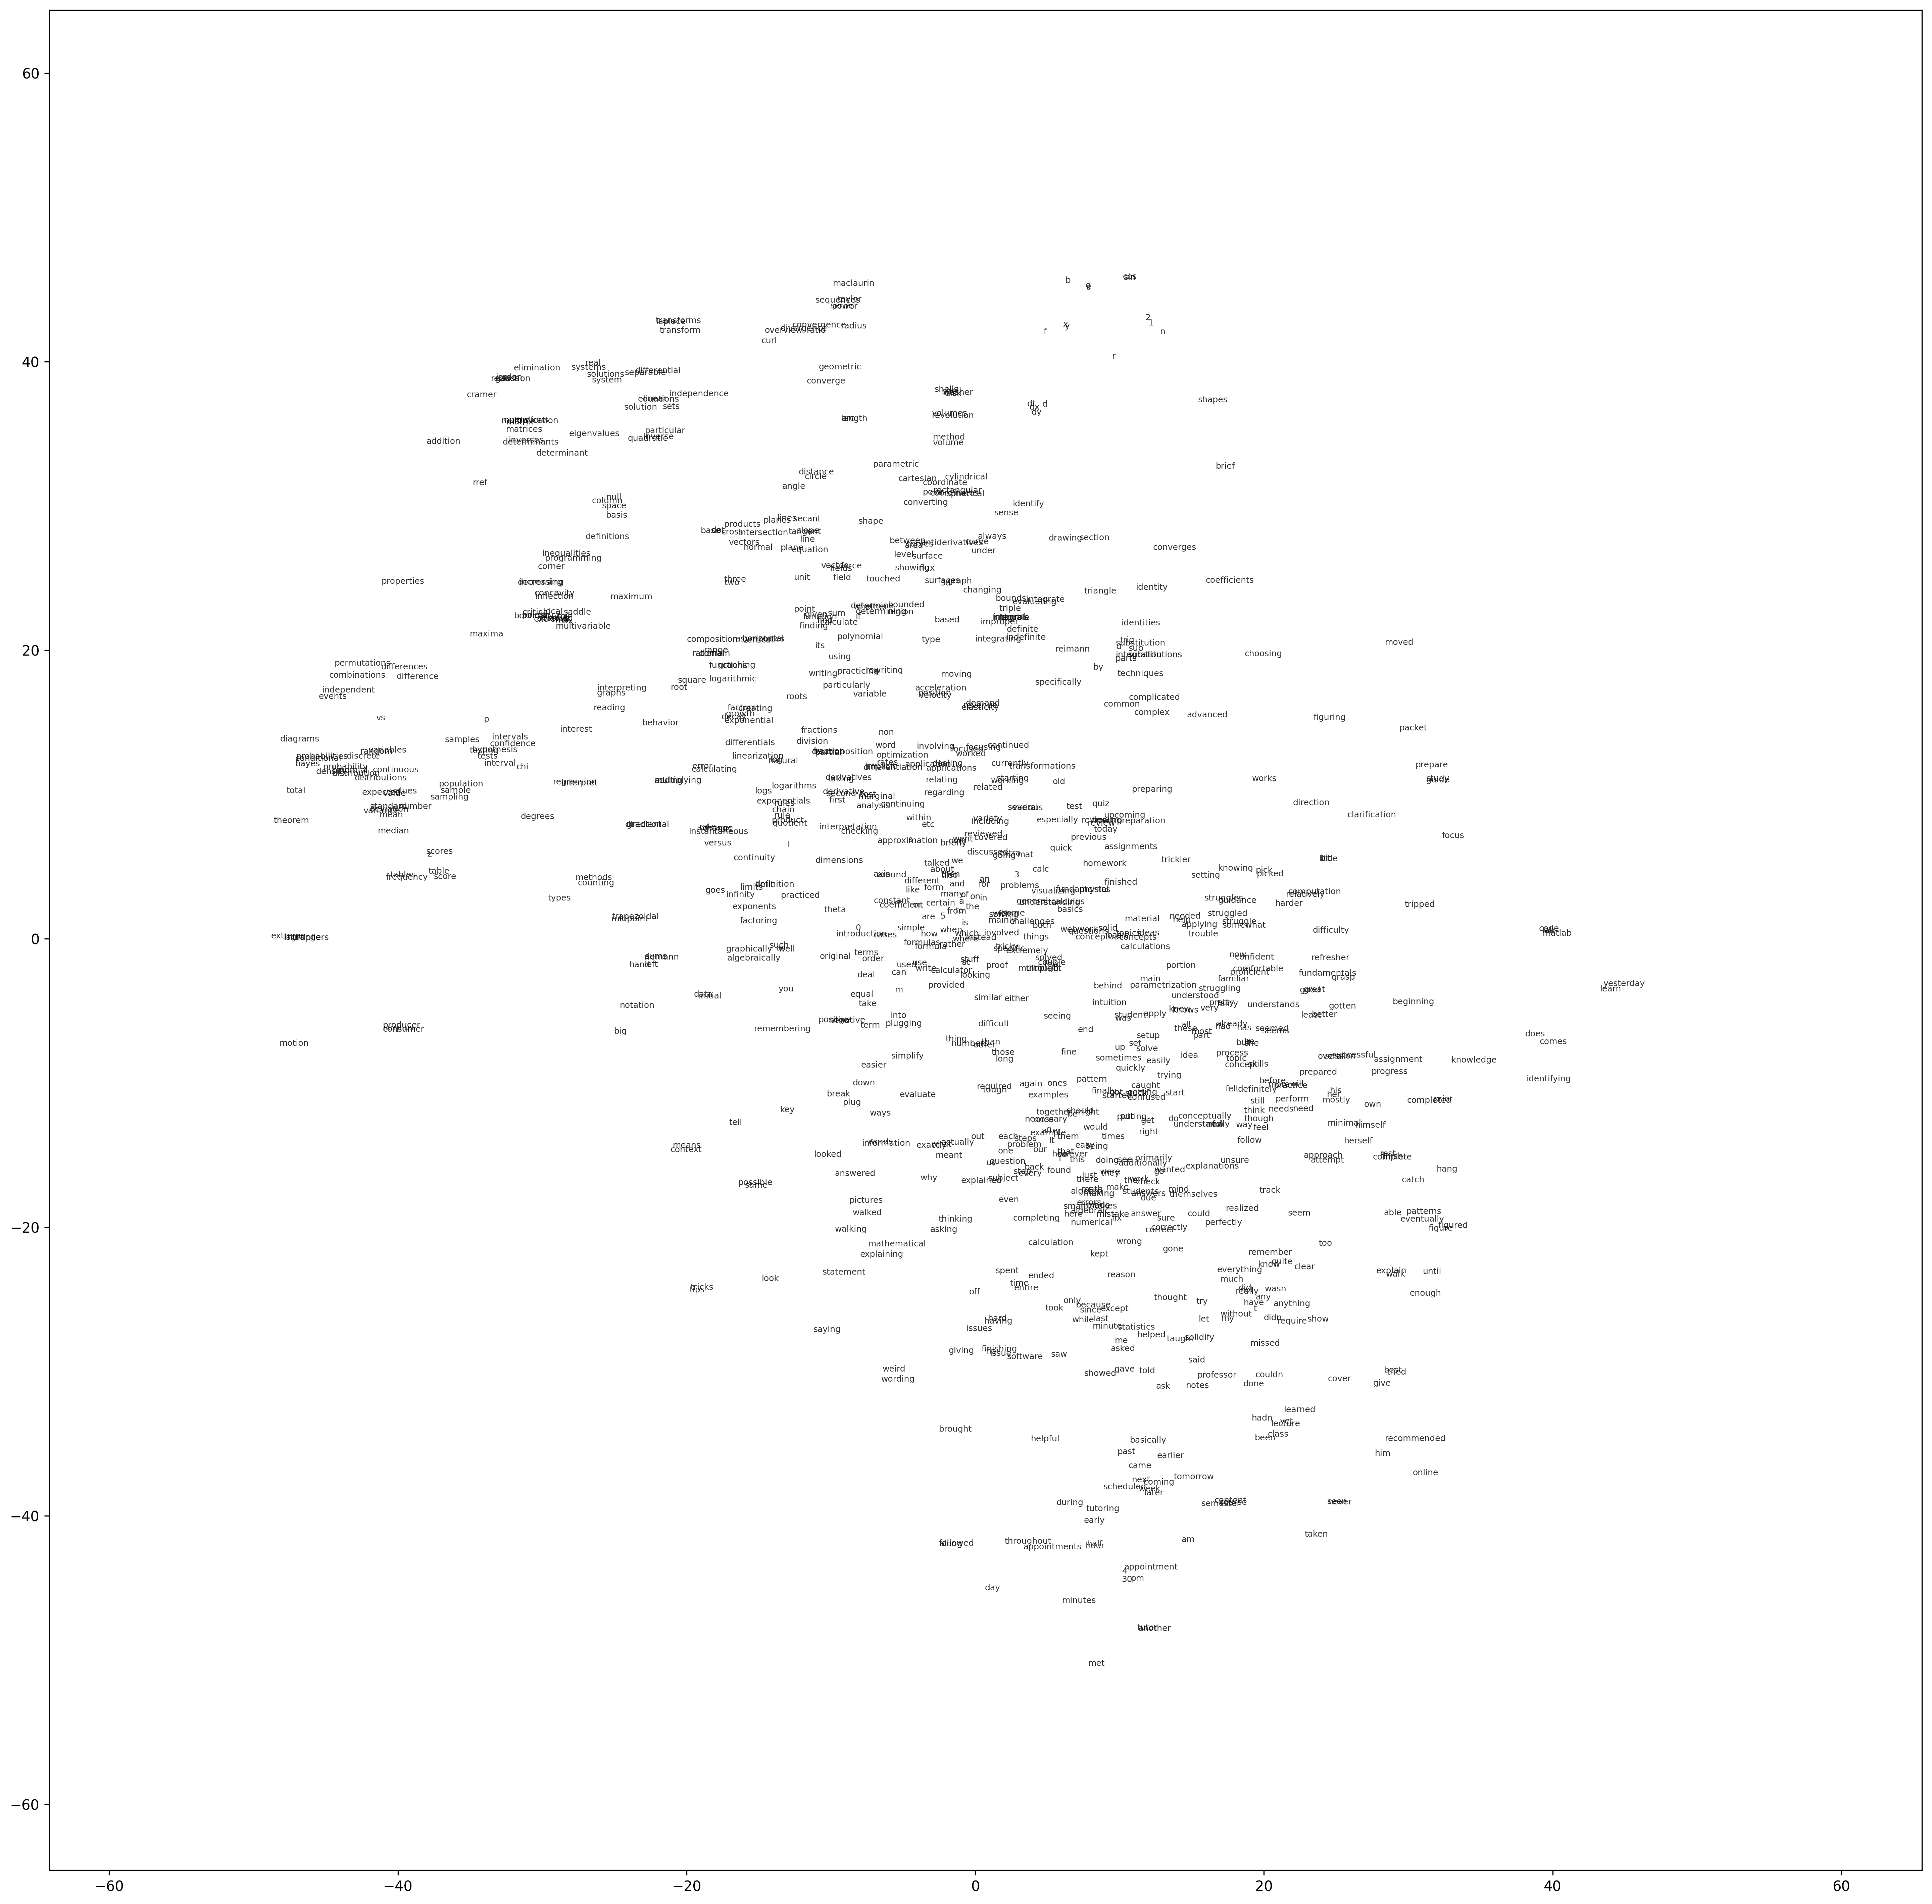

In [100]:
fig, ax1 = plt.subplots(1,1, figsize=(24,24), dpi=300)

ax1.scatter(low_dim_embedding[:,0], low_dim_embedding[:,1], s=0)

#ax1.set_xlim([-20, 0])
#ax1.set_ylim([0, 20])


for i in range(2, 932,1): # range(50,2000,5):
    ax1.text(low_dim_embedding[i,0], low_dim_embedding[i,1], labels[i], fontsize=6, alpha=.8);